In [7]:
import numpy as np 
import matplotlib.pyplot as plt
from hodalpt.sims import alpt as CS
from hodalpt.sims import quijote as Q
from hodalpt import stats


Config file ranges for priors 
CMASS-like sample 
Vary uniform distribution for those parameters 

- sample params 
- runs alpt
- plot power spectra 
- after the DM, just do the bias for different realizations 
- look at the power spectrum in redshift space 
- compare to the Rockstar HOD catalogs 
- mock challenge median values 
once things going want to update the ICs (going to use different realization altogether)
*512^3 is relatively low, only halo masses ~10^{13} want to be safely clear of 13.0

Fiducial_HR quijote JUST ICS and halo catalogs 
only interfacing with the ICS 
cosmic signals doesn’t scale with # particles, doesn't scale with #part 

Eventually move to latin hypercubes 

In [2]:
# ics = Q.IC('/Users/mcc3842/CosmicSim2025/data/quijote/fiducial/1')
ics = Q.IC('/Users/mcc3842/CosmicSim2025/data/quijote/latin_hypercube_HR/0')

In [8]:
fconfig = '/Users/mcc3842/CosmicSim2025/CosmicSignal4SimBIG/boxes/config_file.ini'#'/Users/hahnchanghoon/projects/CosmicSignal4SimBIG/boxes/config_file.ini'
outdir = '/Users/mcc3842/CosmicSim2025/data/quijote/latin_hypercube_HR/0/alpt/'

In [3]:
# HOD for quijote 
theta_hod = {
    'logMmin': 13.06,
    'sigma_logM': 0.34,
    'logM0': 13.74,
    'logM1': 14.17,
    'alpha': 0.69,
    'Abias': 0.1, 
    'eta_conc': 1.12,
    'eta_cen': 0.3,
    'eta_sat': 1.26}
hod_quijote = Q.HODgalaxies(theta_hod,'/Users/mcc3842/CosmicSim2025/data/quijote/latin_hypercube_HR/0', z=0.5)
# get redshift-space positions
xyz_q = Q.Box_RSD(hod_quijote, LOS=[0,0,1], Lbox=1000.) # in z-direction
hod_Q_spec = stats.Pk_periodic(xyz_q.T, Lbox=1000, Ngrid=256, Nmubin=20, fft='pyfftw', silent=False,rsd=2)
k_bins_allk = hod_Q_spec['k']
P_nbody_allk = hod_Q_spec['p0k']

/opt/homebrew/Caskroom/miniconda/base/envs/simbig/lib/python3.11/site-packages/halotools/empirical_models/phase_space_models/analytic_models/satellites/nfw/biased_nfw_phase_space.py:225: UserWarning: You have selected 18 bins to digitize host halo concentration 
and 96 bins to digitize the galaxy bias parameter.
To populate mocks, the BiasedNFWPhaseSpace class builds a lookup table with shape (18, 96, 101),
one entry for every numerical solution to the Jeans equation.
Using this fine of a binning requires a long pre-computation of 174528 integrals
.Make sure you actually need to use so many bins
  warn(lookup_table_performance_warning.format(*args))
/opt/homebrew/Caskroom/miniconda/base/envs/simbig/lib/python3.11/site-packages/halotools/empirical_models/factories/hod_model_factory.py:890: UserWarning: The composite model received multiple component models 
with a new_haloprop_func_dict that use the conc_NFWmodel key. 
Ignoring the one that appears in the profile component for satellite

------------------
68009 positions in 1000 box
nbar = 0.000068
68009 positions, Ntot=68009
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---


In [10]:
len(k_bins_allk)

128

In [9]:
k_bins = k_bins_allk[:78]
P_nbody = P_nbody_allk[:78]

In [6]:
xyz = CS.CSbox_alpt(fconfig, outdir, seed=0, make_ics=True, silent=False)

Computing and writing out delta IC
Computing displacement fields at z=0.5
Compiled with MULTITHREAD support, with 10 threads
 >>> web-on: initialising settings....

---> attention: N1= 256
---> attention: redshift= 0


 >>> starting web-on  ...

 >>> web-on initialising cosmological model....

number of chosen redshift snapshots = 1
... reading file Quijote_ICs_delta_z127_n256_CIC.DAT
... writing file deltaICOM0.176OL0.824G256V1000.0.dat
... writing file auxreal.dat
... writing file auxim.dat
 >>> dump power-spectrum in : pk_deltaICOM0.176OL0.824G256V1000.0.dat
-->  sample velocity;  z_min, z_max: 0.5  0.5 
... writing file VEZELDx.dat
... writing file VEZELDy.dat
... writing file VEZELDz.dat
-->  calculate values for: 1 snapshots
redshift=0.5, growth=0.817974
... reading file TWOLPTG256V1000.0.dat
... reading file kernelr5.000000.dat
... reading file kernelr5.000000.dat
... reading file posx.dat
... reading file posy.dat
... reading file posz.dat
... writing file deltaBOXOM0.176OL0.82

In [11]:
# Least squares to fit ALPT to n-body powspec
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
# Starting parameters
theta_gal = {
    'alpha': 1.9230,
    'beta': 2.0253,
    # 'dth': -0.7889,
    'rhoeps': 14.6874,
    'eps': 0.5616, 
    'nmean': 3.3e-4
}
theta_gal_fixed = {
    'dth': -0.7889,
    # 'nmean': 3.3e-4
}

theta_rsd = {
    'bv': 0.7289,
    'bb': 1.1652,
    'betarsd': 1.3136,
    'gamma': 0.4944
}
param_names = list(theta_gal.keys()) + list(theta_rsd.keys())
theta_init = np.array(list(theta_gal.values()) + list(theta_rsd.values()))

#bounds = [(val * 0.7, val * 1.3) if val > 0 else (val * 1.3, val * 0.7) 
          #for val in theta_init]

# custom bounds 
bounds = [(1.,3.5), (1.,3.5), (7.,21.), (0.1,0.9),(3.3e-4,2.0e-3), (0.35,1.05), (0.58,1.74),(0.65,1.95),(0.25,0.75)]
def run_alpt_and_measure_pk(theta_gal_dict, theta_rsd_dict):
    """
    Your function that:
    1. Takes parameter dictionary
    2. Runs ALPT simulation
    3. Measures P(k)
    4. Returns P_alpt at your k_bins
    """
    
    xyz_g = CS.CSbox_galaxy(theta_gal_dict, theta_rsd_dict, outdir, silent=True)
    alpt_spec = stats.Pk_periodic(xyz_g.T, Lbox=1000, Ngrid=256, Nmubin=20, fft='pyfftw', silent=False,rsd=2)
    kbins_alpt_allk = alpt_spec['k']
    P_alpt_allk = alpt_spec['p0k']
    return P_alpt_allk[:78]
    
# def params_array_to_dict(params_array):
#     """Convert parameter array back to dictionaries"""
#     theta_gal_new = {name: params_array[i] for i, name in enumerate(list(theta_gal.keys()))}
#     theta_rsd_new = {name: params_array[i+6] for i, name in enumerate(list(theta_rsd.keys()))}
#     return theta_gal_new, theta_rsd_new
def params_array_to_dict(params_array):
    """Convert parameter array back to dictionaries"""
    theta_gal_new = {name: params_array[i] for i, name in enumerate(list(theta_gal.keys()))}
    theta_gal_new.update(theta_gal_fixed)
    theta_rsd_new = {name: params_array[i+5] for i, name in enumerate(list(theta_rsd.keys()))}
    print(theta_gal_new,theta_rsd_new)
    return theta_gal_new, theta_rsd_new


def chi_squared(params_array):
    """Objective function for minimizer"""
    # Convert array to dictionaries
    theta_gal_new, theta_rsd_new = params_array_to_dict(params_array)
    
    # Run ALPT with these parameters
    P_alpt = run_alpt_and_measure_pk(theta_gal_new, theta_rsd_new)
    # Compute chi-squared (simple 1/P^2 weighting)
    # weights = 1.0 / P_nbody**2
    # weights = 1.0/P_nbody
    # chi2 = np.sum(weights * (P_nbody - P_alpt)**2)
    
    # logarithmic residuals 
    chi2 = np.sum((np.log(P_nbody) - np.log(P_alpt))**2)
    
    print(f"χ² = {chi2:.2f}")  # Monitor progress
    return chi2
# Run optimization
result = differential_evolution(
    chi_squared,
    bounds,
    maxiter=50,           # Number of generations
    popsize=10,           # Population size (10 * 9 params = 90 evaluations per generation)
    workers=1,            # Parallel workers (set to 1 for now)
    seed=42,              # Reproducibility
    disp=True,            # Show progress
    polish=False,         # Don't do final L-BFGS-B refinement (faster)
    atol=0.01,            # Absolute tolerance
    tol=0.01              # Relative tolerance
)
# result = minimize(
#     chi_squared,
#     theta_init,
#     method='L-BFGS-B',  # Good for bounded optimization
#     bounds=bounds,
#     options={'disp': True, 'maxiter': 10}
# )
theta_best = result.x
theta_gal_best, theta_rsd_best = params_array_to_dict(theta_best)

print("\nBest-fit parameters:")
print("Galaxy bias:", theta_gal_best)
print("RSD:", theta_rsd_best)
print(f"Final χ² = {result.fun:.2f}")

{'alpha': np.float64(3.0623877146773477), 'beta': np.float64(2.2341387229826397), 'rhoeps': np.float64(17.370508981547715), 'eps': np.float64(0.26742491107190436), 'nmean': np.float64(0.0003328950125504319), 'dth': -0.7889} {'bv': np.float64(0.8430842216402765), 'bb': np.float64(1.0581498625150574), 'betarsd': np.float64(1.4489153989019137), 'gamma': np.float64(0.6090744491906486)}
-->Find starting indices ...
-->Start loop over cells of the mesh ...
------------------
332415 positions in 1000 box
nbar = 0.000332
332415 positions, Ntot=332415
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---
χ² = 8.63
{'alpha': np.float64(1.267313836856321), 'beta': np.float64(1.6874025390310563), 'rhoeps': np.float64(9.10611990429799), 'eps': np.float64(0.49781815888075276), 'nmean': np.float64(0.0017695629758863974), 'dth': -0.7889} {'bv': np.float64(0.4316184101939452), 'bb': np.float64(1.34363248664469), 'betarsd': np.float64(0.6625114332167492), 'gamma'

: 

In [ ]:
theta_gal_best = {'alpha': np.float64(2.7224352930464684), 
'beta': np.float64(2.1983581084269113), 
'rhoeps': np.float64(19.596460460686796), 
'eps': np.float64(0.7450682374772234), 
'nmean': np.float64(0.0016360115348474581), 

'dth': -0.7889} 

theta_rsd_best = {'bv': np.float64(0.6168066511689074), 
'bb': np.float64(0.8050164982935095), 
'betarsd': np.float64(1.057623639942566), 
'gamma': np.float64(0.3339607469592004)}

OM0.176OL0.824G256V1000.0_ALPTrs5.000z0.500.dat
Omega_m 0.176000
Reading input ...
Getting number counts via parametric bias ...
Number counts diagnostics (min, max, mean):  0.0 408.0 0.09752166271209717
Preparing galaxy positions ...
Sampling galaxy positions ...
-->Find starting indices ...
-->Start loop over cells of the mesh ...
apply RSD ...
------------------
1636142 positions in 1000 box
nbar = 0.001636
1636142 positions, Ntot=1636142
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---


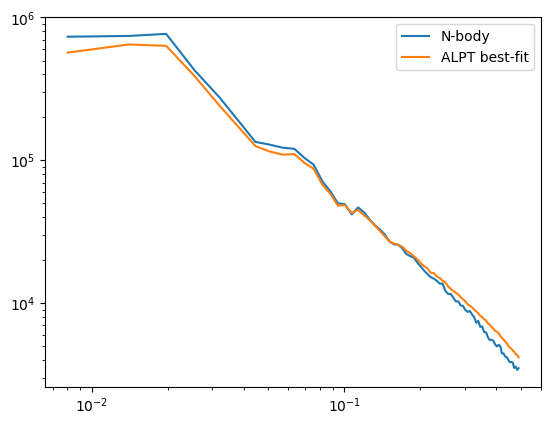

In [10]:
xyz_g = CS.CSbox_galaxy(theta_gal_best, theta_rsd_best, outdir, silent=False)
spec_bf = stats.Pk_periodic(xyz_g.T, Lbox=1000, Ngrid=256, Nmubin=20, fft='pyfftw', silent=False,rsd=2)
P_alpt_bf = spec_bf['p0k'][:78]

plt.loglog(k_bins, P_nbody, label='N-body')
plt.loglog(k_bins, P_alpt_bf, label='ALPT best-fit')
plt.legend()

In [40]:
theta_gal_best['alpha']

np.float64(2.7224352930464684)

In [14]:
quijote_bispec = stats.B0_periodic(xyz_q.T, w=None, Lbox=1000., fft='pyfftw', silent=True)


In [ ]:
alpt_bispec = stats.B0_periodic(xyz_g.T, w=None, Lbox=1000., fft='pyfftw', silent=True)

In [33]:
i_k1 = alpt_bispec['i_k1']
i_k2 = alpt_bispec['i_k2']
i_k3 = alpt_bispec['i_k3']

k_fund = 2 * np.pi / 1000.

k1 = i_k1 * k_fund
k2 = i_k2 * k_fund
k3 = i_k3 * k_fund

b123_alpt = alpt_bispec['b123']
b123_quijote = quijote_bispec['b123']

q123_alpt = alpt_bispec['q123']
q123_quijote = quijote_bispec['q123']

In [43]:
def bispec_del(theta_gal, theta_rsd, parname, delta):
    theta_gal[parname] = theta_gal[parname].copy() * delta
    xyz_g_del = CS.CSbox_galaxy(theta_gal, theta_rsd, outdir, silent=False)
    alpt_bispec_del = stats.B0_periodic(xyz_g_del.T, w=None, Lbox=1000., fft='pyfftw', silent=True)
    i_k1 = alpt_bispec_del['i_k1']
    i_k2 = alpt_bispec_del['i_k2']
    i_k3 = alpt_bispec_del['i_k3']

    k_fund = 2 * np.pi / 1000.

    k1 = i_k1 * k_fund
    k2 = i_k2 * k_fund
    k3 = i_k3 * k_fund

    b123_alpt_del = alpt_bispec_del['b123']
    klim = (k1 < 0.5) & (k2 < 0.5) & (k3 < 0.5)
    return klim, b123_alpt_del


In [53]:
theta_gal_del = theta_gal_best.copy()
theta_gal_del['alpha'] = theta_gal_best['alpha'].copy() * 1.3
xyz_g_del = CS.CSbox_galaxy(theta_gal_del, theta_rsd_best, outdir, silent=False)
alpt_bispec_del = stats.B0_periodic(xyz_g_del.T, w=None, Lbox=1000., fft='pyfftw', silent=True)

OM0.176OL0.824G256V1000.0_ALPTrs5.000z0.500.dat
Omega_m 0.176000
Reading input ...
Getting number counts via parametric bias ...
Number counts diagnostics (min, max, mean):  0.0 458949.0 0.10894578695297241
Preparing galaxy positions ...
Sampling galaxy positions ...
-->Find starting indices ...
-->Start loop over cells of the mesh ...
apply RSD ...


In [50]:
klim, b123_alpt_del = bispec_del(theta_gal_best, theta_rsd_best, parname='alpha', delta=1.3)

OM0.176OL0.824G256V1000.0_ALPTrs5.000z0.500.dat
Omega_m 0.176000
Reading input ...
Getting number counts via parametric bias ...
Number counts diagnostics (min, max, mean):  0.0 68762.0 0.09421586990356445
Preparing galaxy positions ...
Sampling galaxy positions ...
-->Find starting indices ...
-->Start loop over cells of the mesh ...
apply RSD ...


In [58]:
b123_alpt_del[klim]

array([4.05760236e+14, 3.74060839e+14, 3.52731577e+14, ...,
       3.96210037e+13, 3.84204185e+13, 3.71663137e+13], shape=(1898,))

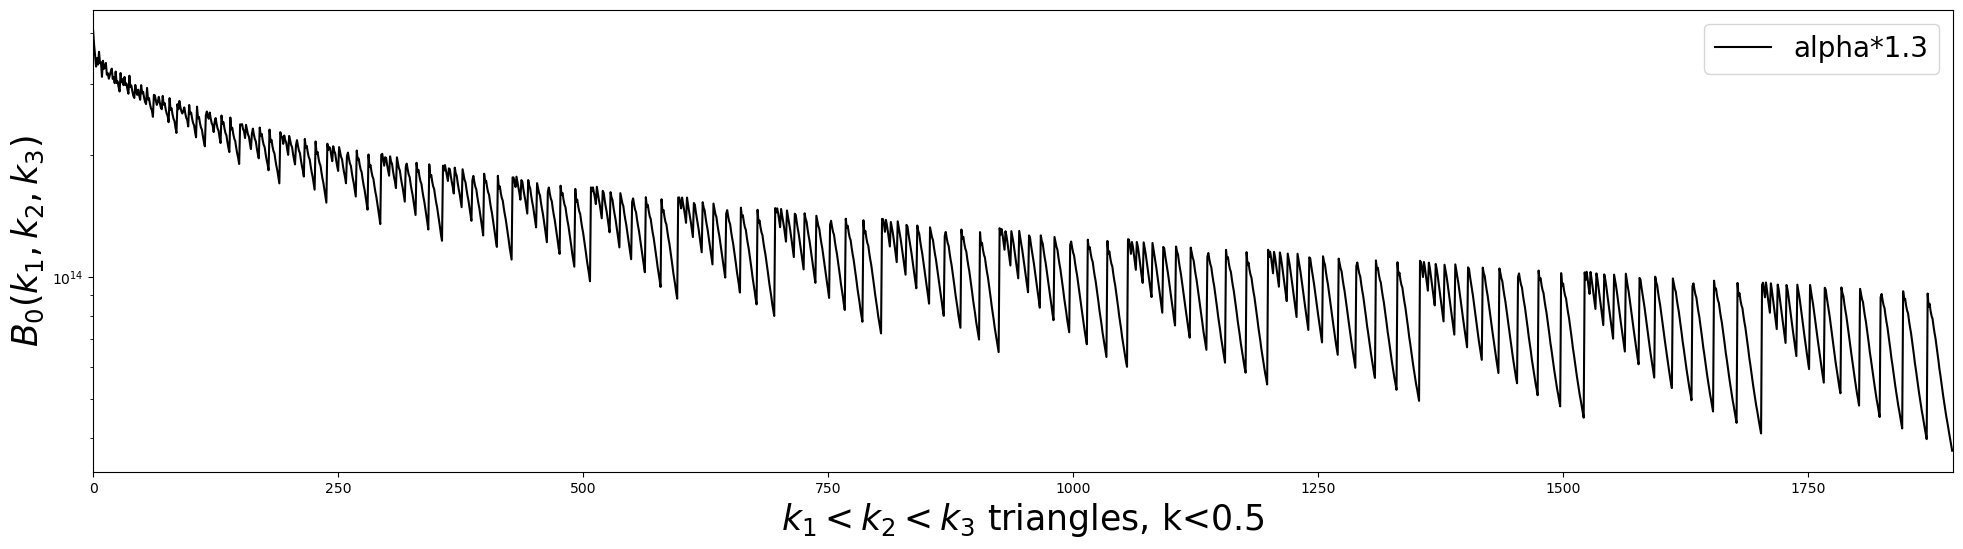

In [59]:
fig = plt.figure(figsize=(24,6))
sub = fig.add_subplot(111)


# sub.plot(range(np.sum(klim)), b123_alpt[klim], color='C0', label='alpt ref')
sub.plot(range(np.sum(klim)), b123_alpt_del[klim], color='black', label=str('alpha')+'*'+str(1.3))
sub.set_ylabel(r'$B_0(k_1,k_2,k_3)$', fontsize=25)
sub.set_yscale('log')
sub.set_xlim(0, np.sum(klim))
# sub.set_ylim(1e6, 1e11)
sub.set_xlabel('$k_1 < k_2 < k_3$ triangles, k<0.5', fontsize=25)
sub.legend(fontsize=20)

In [60]:
def plot_del_B0(b123_alpt_ref, parname, delta):
    klim, b123_alpt_del = bispec_del(theta_gal_best, theta_rsd_best, parname=parname, delta=delta)

    fig = plt.figure(figsize=(24,6))
    sub = fig.add_subplot(111)


    sub.plot(range(np.sum(klim)), b123_alpt_ref[klim], color='C0', label='alpt ref')
    sub.plot(range(np.sum(klim)), b123_alpt_del[klim], color='black', label=str(parname)+'*'+str(delta))
    sub.set_ylabel(r'$B_0(k_1,k_2,k_3)$', fontsize=25)
    sub.set_yscale('log')
    sub.set_xlim(0, np.sum(klim))
    # sub.set_ylim(1e6, 1e11)
    sub.set_xlabel('$k_1 < k_2 < k_3$ triangles, k<0.5', fontsize=25)
    sub.legend(fontsize=20)
    return

OM0.176OL0.824G256V1000.0_ALPTrs5.000z0.500.dat
Omega_m 0.176000
Reading input ...
Getting number counts via parametric bias ...
Number counts diagnostics (min, max, mean):  0.0 65914.0 0.09510773420333862
Preparing galaxy positions ...
Sampling galaxy positions ...
-->Find starting indices ...
-->Start loop over cells of the mesh ...
apply RSD ...


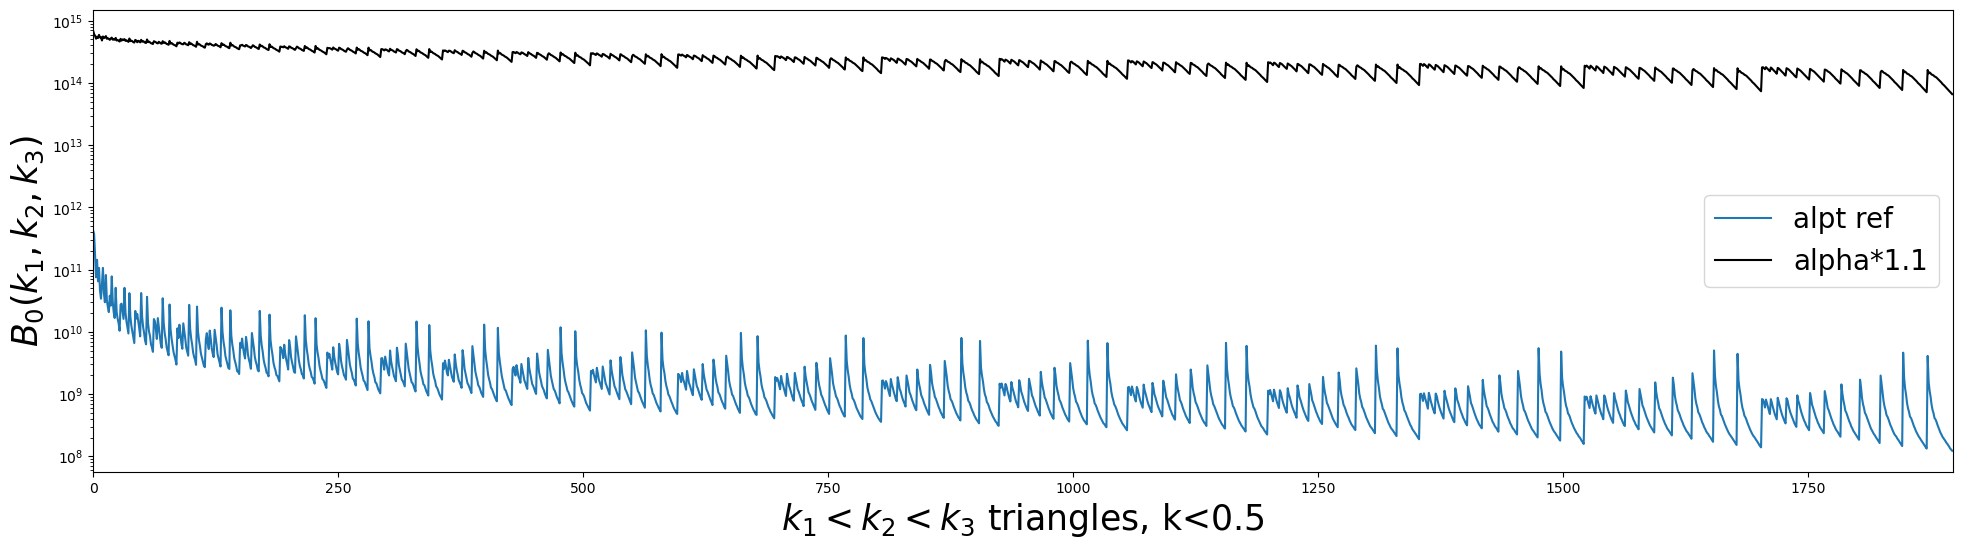

In [ ]:
plot_del_B0(b123_alpt, 'alpha', 1.1)

In [62]:
plot_del_B0(b123_alpt, 'beta', 1.1)

OM0.176OL0.824G256V1000.0_ALPTrs5.000z0.500.dat
Omega_m 0.176000
Reading input ...
Getting number counts via parametric bias ...
Number counts diagnostics (min, max, mean):  0.0 126740.0 0.09810233116149902
Preparing galaxy positions ...
Sampling galaxy positions ...
-->Find starting indices ...
-->Start loop over cells of the mesh ...
apply RSD ...


KeyboardInterrupt: 

Text(0.5, 0, '$k_1 < k_2 < k_3$ triangles, k<0.5')

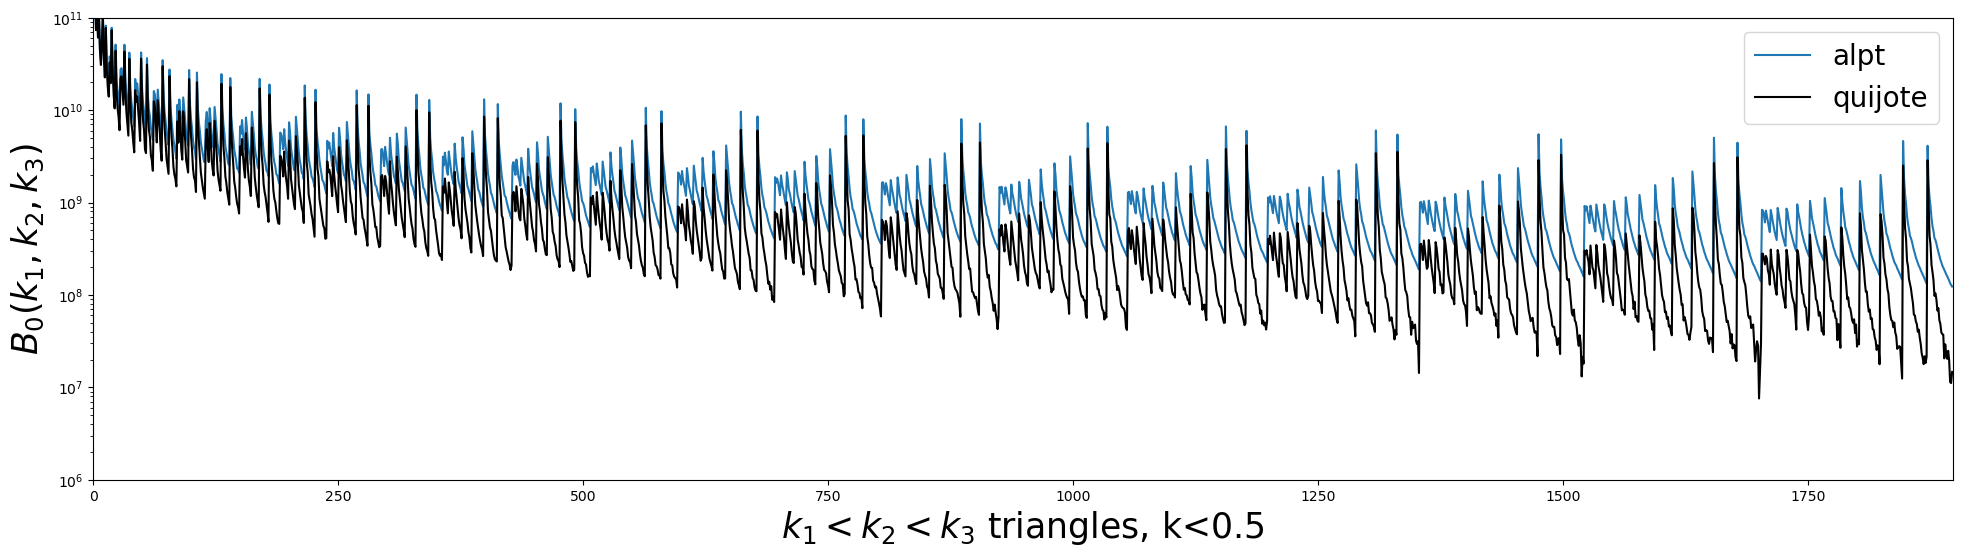

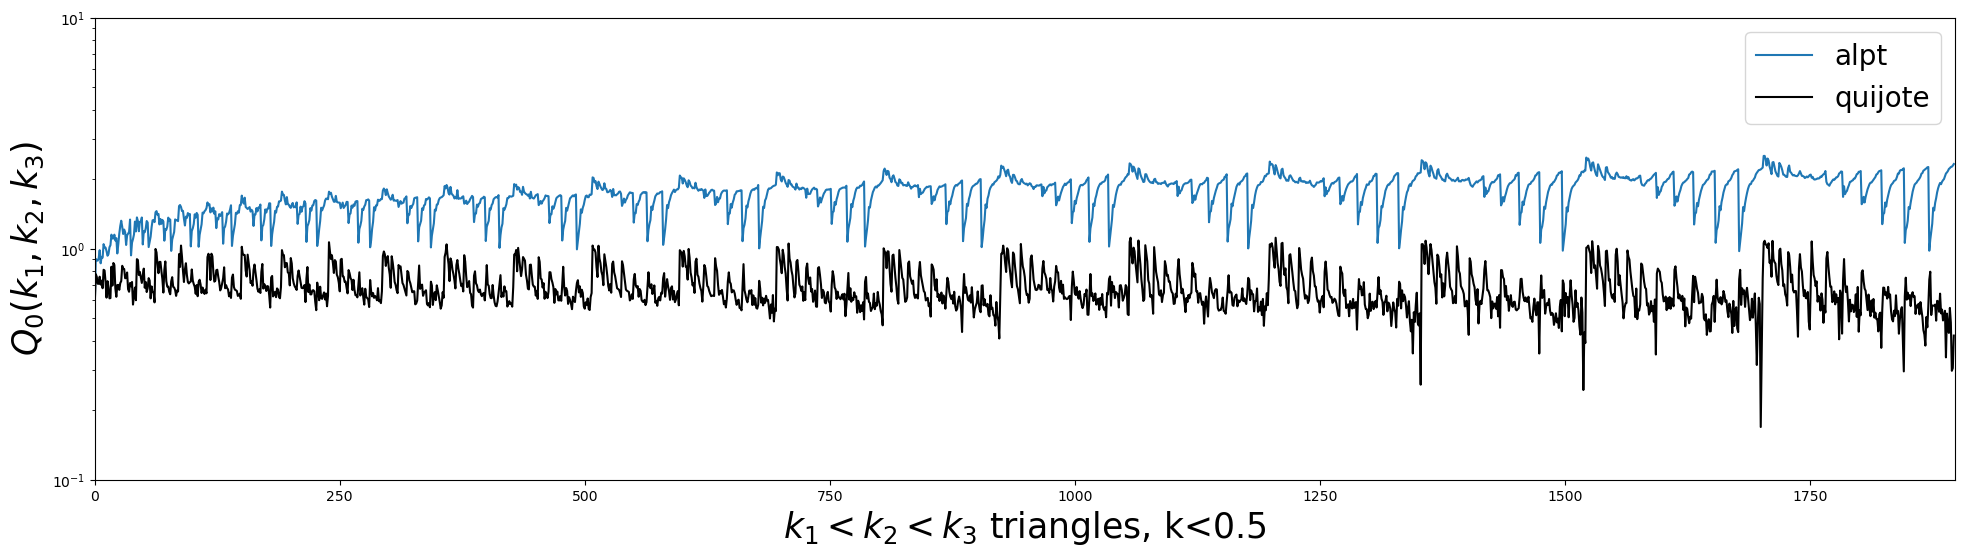

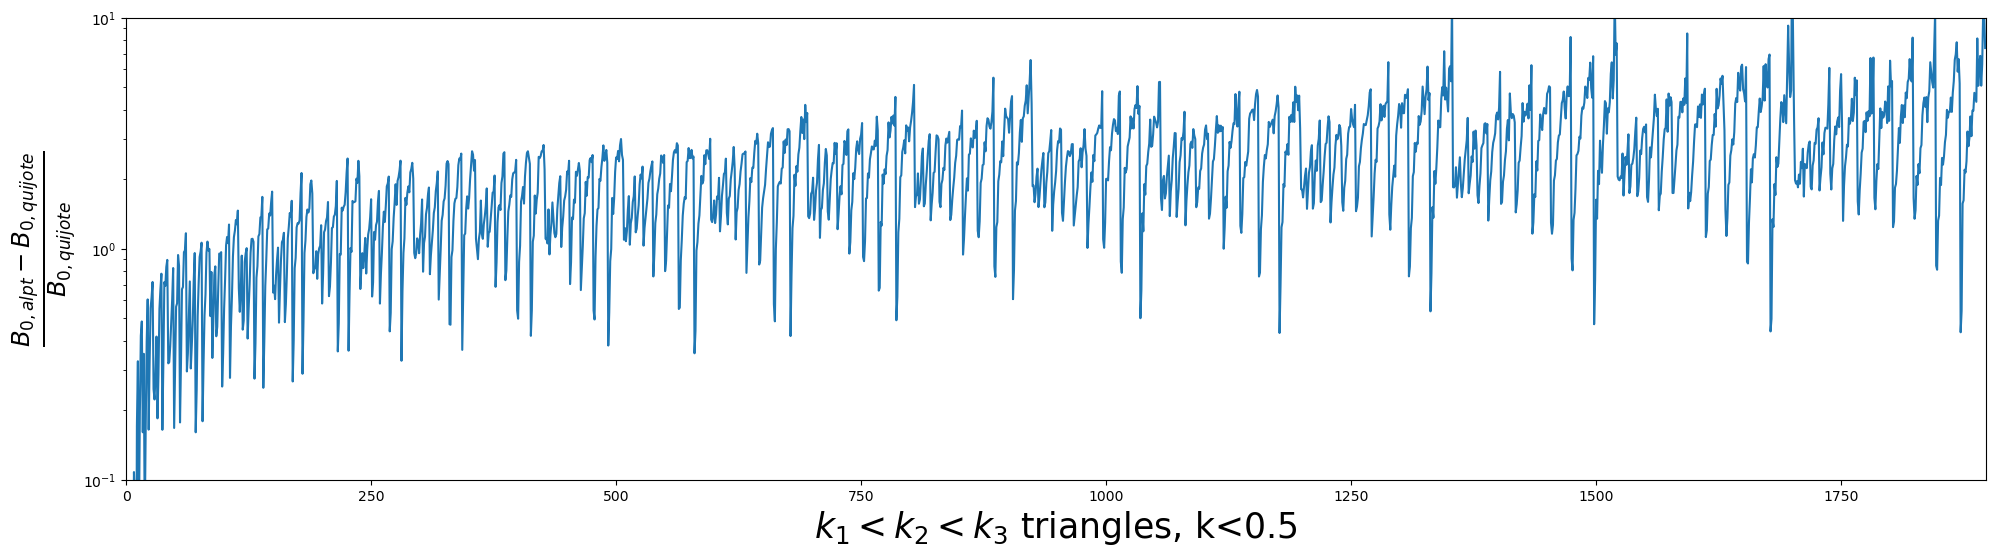

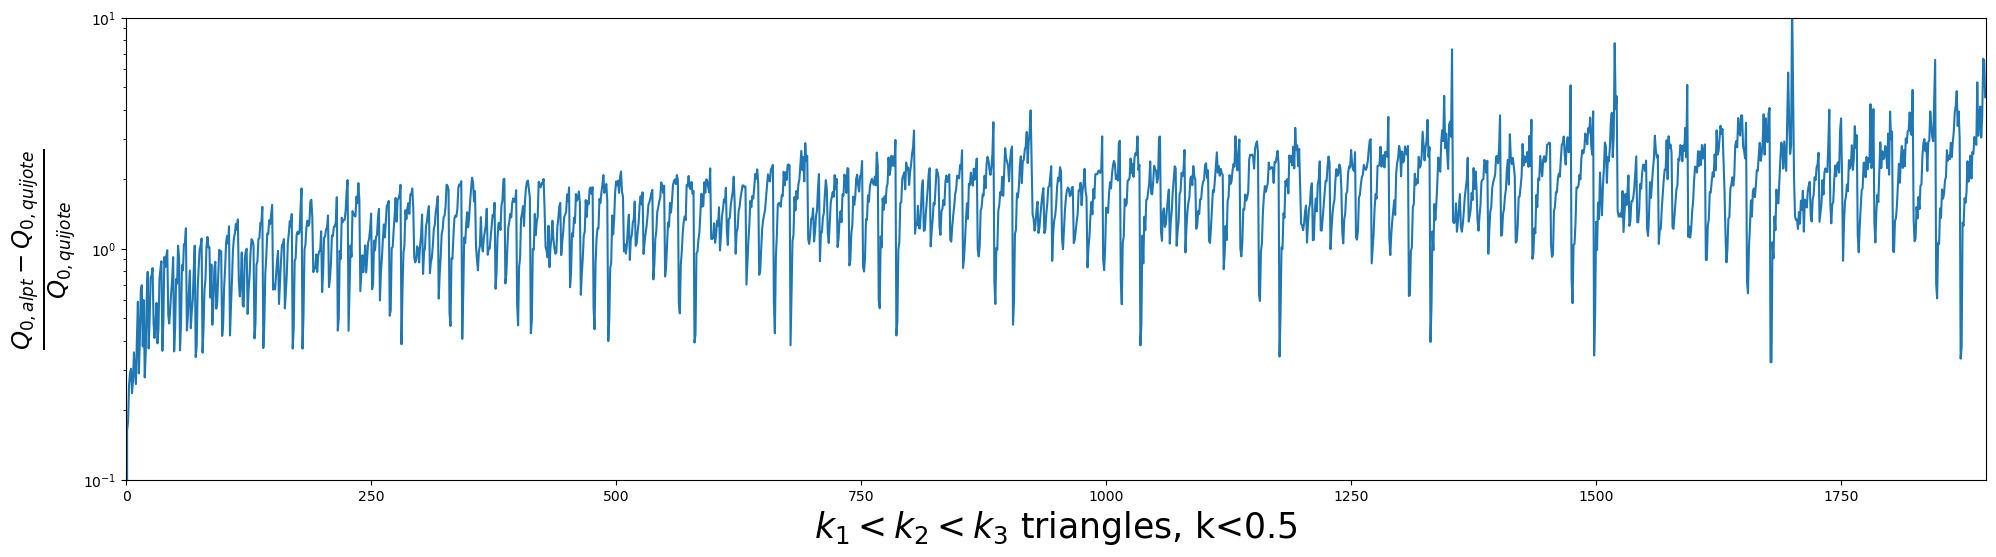

In [39]:


fig = plt.figure(figsize=(24,6))
sub = fig.add_subplot(111)

klim = (k1 < 0.5) & (k2 < 0.5) & (k3 < 0.5)

sub.plot(range(np.sum(klim)), b123_alpt[klim], color='C0', label='alpt')
sub.plot(range(np.sum(klim)), b123_quijote[klim], color='black', label='quijote')
sub.set_ylabel(r'$B_0(k_1,k_2,k_3)$', fontsize=25)
sub.set_yscale('log')
sub.set_xlim(0, np.sum(klim))
sub.set_ylim(1e6, 1e11)
sub.set_xlabel('$k_1 < k_2 < k_3$ triangles, k<0.5', fontsize=25)
sub.legend(fontsize=20)

fig = plt.figure(figsize=(24,6))
sub = fig.add_subplot(111)

sub.plot(range(np.sum(klim)), q123_alpt[klim], color='C0',label='alpt')
sub.plot(range(np.sum(klim)), q123_quijote[klim], color='black',label='quijote')
sub.set_ylabel(r'$Q_0(k_1,k_2,k_3)$', fontsize=25)
sub.set_xlim(0, np.sum(klim))
sub.set_yscale('log')
sub.set_ylim(1e-1, 1e1)
sub.set_xlabel('$k_1 < k_2 < k_3$ triangles, k<0.5', fontsize=25)
sub.legend(fontsize=20)

fig = plt.figure(figsize=(24,6))
sub = fig.add_subplot(111)

sub.plot(range(np.sum(klim)), (b123_alpt[klim]-b123_quijote[klim])/b123_quijote[klim], color='C0')

sub.set_ylabel(r'$\frac{B_{0,alpt}-B_{0,quijote}}{B_{0,quijote}}$', fontsize=25)
sub.set_xlim(0, np.sum(klim))
sub.set_yscale('log')
sub.set_ylim(1e-1, 1e1)
sub.set_xlabel('$k_1 < k_2 < k_3$ triangles, k<0.5', fontsize=25)

fig = plt.figure(figsize=(24,6))
sub = fig.add_subplot(111)

sub.plot(range(np.sum(klim)), (q123_alpt[klim]-q123_quijote[klim])/q123_quijote[klim], color='C0')

sub.set_ylabel(r'$\frac{Q_{0,alpt}-Q_{0,quijote}}{Q_{0,quijote}}$', fontsize=25)
sub.set_xlim(0, np.sum(klim))
sub.set_yscale('log')
sub.set_ylim(1e-1, 1e1)
sub.set_xlabel('$k_1 < k_2 < k_3$ triangles, k<0.5', fontsize=25)



In [11]:
print("=== DIAGNOSTICS ===")
print(f"Success: {result.success}")
print(f"Status: {result.status}")
print(f"Message: {result.message}")
print(f"Iterations: {result.nfev}")
print(f"Final χ²: {result.fun}")
print(f"Final params: {result.x}")

=== DIAGNOSTICS ===


NameError: name 'result' is not defined

In [15]:
theta_test = theta_init.copy()
theta_test[0] = theta_init[0] * 1.2  # Change alpha by 20%

chi2_initial = chi_squared(theta_init)
chi2_perturbed = chi_squared(theta_test)

print(f"Initial χ²: {chi2_initial}")
print(f"Perturbed χ² (alpha +20%): {chi2_perturbed}")
print(f"Difference: {chi2_perturbed - chi2_initial}")

{'alpha': np.float64(2.5), 'beta': np.float64(2.0253), 'rhoeps': np.float64(14.6874), 'eps': np.float64(0.5616), 'dth': -0.7889, 'nmean': 0.00033} {'bv': np.float64(0.7289), 'bb': np.float64(1.1652), 'betarsd': np.float64(1.3136), 'gamma': np.float64(0.4944)}
-->Find starting indices ...
-->Start loop over cells of the mesh ...
------------------
330576 positions in 1000 box
nbar = 0.000331
330576 positions, Ntot=330576
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---
χ² = 10.61
{'alpha': np.float64(3.0), 'beta': np.float64(2.0253), 'rhoeps': np.float64(14.6874), 'eps': np.float64(0.5616), 'dth': -0.7889, 'nmean': 0.00033} {'bv': np.float64(0.7289), 'bb': np.float64(1.1652), 'betarsd': np.float64(1.3136), 'gamma': np.float64(0.4944)}
-->Find starting indices ...
-->Start loop over cells of the mesh ...
------------------
329565 positions in 1000 box
nbar = 0.000330
329565 positions, Ntot=329565
positions assigned to grid
position grid FFTed

Best-fit parameters:
Galaxy bias: {'alpha': np.float64(1.9230002807923452), 'beta': np.float64(2.025300338311699), 'dth': np.float64(-0.788900277209533), 'rhoeps': np.float64(14.687402798258692), 'eps': np.float64(0.5615996832685418), 'nmean': np.float64(0.0003301685512201253)}
RSD: {'bv': np.float64(0.7288997804556778), 'bb': np.float64(1.1652003869151486), 'betarsd': np.float64(1.3136002412075691), 'gamma': np.float64(0.49439985934908587)}
Final χ² = 45.98

In [19]:
theta_gal_bf = {'alpha': np.float64(1.9230002807923452), 
                'beta': np.float64(2.025300338311699), 
                'dth': np.float64(-0.788900277209533), 
                'rhoeps': np.float64(14.687402798258692), 
                'eps': np.float64(0.5615996832685418), 
                'nmean': np.float64(0.0003301685512201253)}

theta_rsd_bf = {'bv': np.float64(0.7288997804556778), 
                'bb': np.float64(1.1652003869151486), 
                'betarsd': np.float64(1.3136002412075691), 
                'gamma': np.float64(0.49439985934908587)}

xyz_g = CS.CSbox_galaxy(theta_gal_bf, theta_rsd_bf, outdir, silent=False)

OM0.317OL0.683G256V1000.0_ALPTrs5.000z0.500.dat
Omega_m 0.317000
Reading input ...
Getting number counts via parametric bias ...
Number counts diagnostics (min, max, mean):  0.0 16.0 0.019706368446350098
Preparing galaxy positions ...
Sampling galaxy positions ...
-->Find starting indices ...
-->Start loop over cells of the mesh ...
apply RSD ...


In [20]:
spec_bf = stats.Pk_periodic(xyz_g.T, Lbox=1000, Ngrid=256, Nmubin=20, fft='pyfftw', silent=False,rsd=2)
P_alpt_bf = spec_bf['p0k'][:78]

------------------
330618 positions in 1000 box
nbar = 0.000331
330618 positions, Ntot=330618
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---


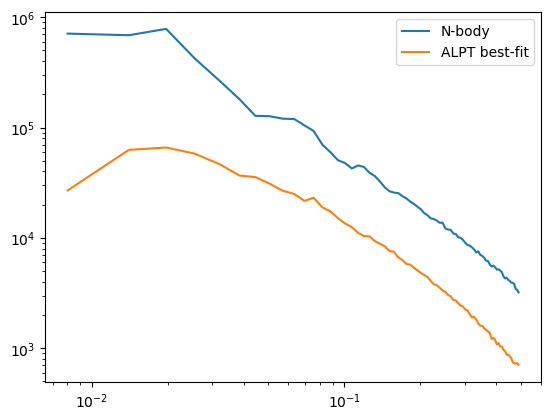

In [22]:

plt.loglog(k_bins, P_nbody, label='N-body')
plt.loglog(k_bins, P_alpt_bf, label='ALPT best-fit')
plt.legend()
# plt.plot(k_bins, residuals, label='Fractional residual')

In [14]:
# generate ALPT DM
xyz = CS.CSbox_alpt(fconfig, outdir, seed=0, make_ics=True, silent=False)

Computing and writing out delta IC
Computing displacement fields at z=0.5
Compiled with MULTITHREAD support, with 10 threads
 >>> web-on: initialising settings....

---> attention: N1= 256
---> attention: redshift= 0


 >>> starting web-on  ...

 >>> web-on initialising cosmological model....

... writing file kernelr5.000000.dat
number of chosen redshift snapshots = 1
... writing file posx.dat
... writing file posy.dat
... writing file posz.dat
... writing file posorx.dat
... writing file posory.dat
... writing file posorz.dat
... writing file posor0x.dat
... writing file posor0y.dat
... writing file posor0z.dat
... reading file Quijote_ICs_delta_z127_n256_CIC.DAT
... writing file deltaICOM0.317OL0.683G256V1000.0.dat
... writing file auxreal.dat
... writing file auxim.dat
 >>> dump power-spectrum in : pk_deltaICOM0.317OL0.683G256V1000.0.dat
-->  sample velocity;  z_min, z_max: 0.5  0.5 
... writing file VEZELDx.dat
... writing file VEZELDy.dat
... writing file VEZELDz.dat
-->  calcula

In [6]:
print( 1.9230 - ( 1.9230* 0.5),',',  1.9230 + ( 1.9230* 0.5))
print(2.0253 - (2.0253*0.5),',', 2.0253 + (2.0253*0.5)),
print(14.6874 - (14.6874*0.5),',', 14.6874 + (14.6874 * 0.5))
print(0.5616 - (0.5616*0.5),',', 0.5616 + (0.5616*0.5))
print(3.3e-4 - (3.3e-4*0.5),',', 3.3e-4 + (3.3e-4*0.5))
print('-----')
print(0.7289 -(0.7289*0.5),',', 0.7289 + (0.7289*0.5))
print(1.1652 - (1.1652*0.5),',', 1.1652 + (1.1652*0.5))
print(1.3136 - (1.3136*0.5),',', 1.3136 + (1.3136*0.5))
print(0.4944 - (0.4944*0.5),',', 0.4944 + (0.4944*0.5))

0.9615 , 2.8845
1.01265 , 3.0379500000000004
7.3437 , 22.031100000000002
0.2808 , 0.8424
0.000165 , 0.000495
-----
0.36445 , 1.09335
0.5826 , 1.7478
0.6568 , 1.9704000000000002
0.2472 , 0.7416


In [4]:
# change Theta_gal 
def make_thetas(seed): 
    rng = np.random.default_rng(seed)
    theta_gal = {
        'alpha':rng.uniform(0.9615, 2.8845),
        'beta':rng.uniform(1.01265, 3.03795),
        'dth':-0.7889,
        'rhoeps':rng.uniform(7.3437 , 22.03110),
        'eps':rng.uniform(0.2808 , 0.8424), 
        'nmean':rng.uniform(0.000165 , 0.000495)
    }
    theta_rsd = {
        'bv':rng.uniform(0.36445 , 1.09335),
        'bb':rng.uniform(0.5826 , 1.7478),
        'betarsd':rng.uniform(0.6568 , 1.97040),
        'gamma': rng.uniform(0.2472 , 0.7416)
    }
    return theta_gal, theta_rsd

def del_theta_gal(theta_gal_default, key):
    delta = theta_gal_default[key] * 0.2
    theta_gal = theta_gal_default.copy()
    theta_gal[key] = theta_gal_default[key] + delta
    return theta_gal

def del_theta_rsd(theta_rsd_default, key):
    delta = theta_rsd_default[key] * 0.2
    theta_rsd = theta_rsd_default.copy()
    theta_rsd[key] = theta_rsd_default[key] + delta
    return theta_rsd

In [5]:
theta_gal = {
        'alpha':1.9230,
        'beta':2.0253,
        'dth':-0.7889,
        'rhoeps':14.6874,
        'eps':0.5616, 
        'nmean':3.3e-4
    }

theta_rsd = {
    'bv': 0.7289,
    'bb': 1.1652,
    'betarsd': 1.3136,
    'gamma': 0.4944
}
thetas = []
pars = ['alpha', 'beta', 'rhoeps', 'eps', 'nmean']
for key in pars:
    thetas.append(del_theta_gal(theta_gal, key))
    print(del_theta_gal(theta_gal, key))


xyz_g_del = CS.CSbox_galaxy(thetas[0], theta_rsd, outdir, silent=False)
spec_del_alpha = stats.Pk_periodic(xyz_g_del.T, Lbox=1000, Ngrid=256, Nmubin=20, fft='pyfftw', silent=False,rsd=2)

xyz_g_del = CS.CSbox_galaxy(thetas[1], theta_rsd, outdir, silent=False)
spec_del_beta = stats.Pk_periodic(xyz_g_del.T, Lbox=1000, Ngrid=256, Nmubin=20, fft='pyfftw', silent=False,rsd=2)

xyz_g_del = CS.CSbox_galaxy(thetas[2], theta_rsd, outdir, silent=False)
spec_del_rhoeps = stats.Pk_periodic(xyz_g_del.T, Lbox=1000, Ngrid=256, Nmubin=20, fft='pyfftw', silent=False,rsd=2)


xyz_g_del = CS.CSbox_galaxy(thetas[3], theta_rsd, outdir, silent=False)
spec_del_eps = stats.Pk_periodic(xyz_g_del.T, Lbox=1000, Ngrid=256, Nmubin=20, fft='pyfftw', silent=False,rsd=2)


xyz_g_del = CS.CSbox_galaxy(thetas[4], theta_rsd, outdir, silent=False)
spec_del_nmean = stats.Pk_periodic(xyz_g_del.T, Lbox=1000, Ngrid=256, Nmubin=20, fft='pyfftw', silent=False,rsd=2)

xyz_g = CS.CSbox_galaxy(theta_gal, theta_rsd, outdir, silent=False)
spec_theta =  stats.Pk_periodic(xyz_g.T, Lbox=1000, Ngrid=256, Nmubin=20, fft='pyfftw', silent=False,rsd=2)






{'alpha': 2.3076, 'beta': 2.0253, 'dth': -0.7889, 'rhoeps': 14.6874, 'eps': 0.5616, 'nmean': 0.00033}
{'alpha': 1.923, 'beta': 2.4303600000000003, 'dth': -0.7889, 'rhoeps': 14.6874, 'eps': 0.5616, 'nmean': 0.00033}
{'alpha': 1.923, 'beta': 2.0253, 'dth': -0.7889, 'rhoeps': 17.62488, 'eps': 0.5616, 'nmean': 0.00033}
{'alpha': 1.923, 'beta': 2.0253, 'dth': -0.7889, 'rhoeps': 14.6874, 'eps': 0.67392, 'nmean': 0.00033}
{'alpha': 1.923, 'beta': 2.0253, 'dth': -0.7889, 'rhoeps': 14.6874, 'eps': 0.5616, 'nmean': 0.000396}
OM0.317OL0.683G256V1000.0_ALPTrs5.000z0.500.dat
Omega_m 0.317000
Reading input ...
Getting number counts via parametric bias ...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


: 

In [10]:
thetas_rsd = []
pars = ['bv', 'bb', 'betarsd', 'gamma']
for key in pars:
    thetas_rsd.append(del_theta_rsd(theta_rsd, key))

xyz_g = CS.CSbox_galaxy(theta_gal, thetas_rsd[0], outdir, silent=False)
spec_del_bv =  stats.Pk_periodic(xyz_g.T, Lbox=1000, Ngrid=256, Nmubin=20, fft='pyfftw', silent=False,rsd=2)

xyz_g = CS.CSbox_galaxy(theta_gal, thetas_rsd[1], outdir, silent=False)
spec_del_bb =  stats.Pk_periodic(xyz_g.T, Lbox=1000, Ngrid=256, Nmubin=20, fft='pyfftw', silent=False,rsd=2)

xyz_g = CS.CSbox_galaxy(theta_gal, thetas_rsd[2], outdir, silent=False)
spec_del_betarsd =  stats.Pk_periodic(xyz_g.T, Lbox=1000, Ngrid=256, Nmubin=20, fft='pyfftw', silent=False,rsd=2)

xyz_g = CS.CSbox_galaxy(theta_gal, thetas_rsd[3], outdir, silent=False)
spec_del_gamma =  stats.Pk_periodic(xyz_g.T, Lbox=1000, Ngrid=256, Nmubin=20, fft='pyfftw', silent=False,rsd=2)



OM0.317OL0.683G256V1000.0_ALPTrs5.000z0.500.dat
Omega_m 0.317000
Reading input ...
Getting number counts via parametric bias ...
Number counts diagnostics (min, max, mean):  0.0 4.0 0.01963144540786743
Preparing galaxy positions ...
Sampling galaxy positions ...
-->Find starting indices ...
-->Start loop over cells of the mesh ...
apply RSD ...
------------------
329361 positions in 1000 box
nbar = 0.000329
329361 positions, Ntot=329361
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---
OM0.317OL0.683G256V1000.0_ALPTrs5.000z0.500.dat
Omega_m 0.317000
Reading input ...
Getting number counts via parametric bias ...
Number counts diagnostics (min, max, mean):  0.0 5.0 0.0196569561958313
Preparing galaxy positions ...
Sampling galaxy positions ...
-->Find starting indices ...
-->Start loop over cells of the mesh ...
apply RSD ...
------------------
329789 positions in 1000 box
nbar = 0.000330
329789 positions, Ntot=329789
positions assigned to gr

In [23]:
finitediff_alpha = (spec_del_alpha['p0k'] - spec_theta['p0k']) / (theta_gal['alpha'] * 0.2)
finitediff_beta = (spec_del_beta['p0k'] - spec_theta['p0k']) / (theta_gal['beta'] * 0.2)
finitediff_rhoeps = (spec_del_rhoeps['p0k'] - spec_theta['p0k']) / (theta_gal['rhoeps'] * 0.2)
finitediff_eps = (spec_del_eps['p0k'] - spec_theta['p0k']) / (theta_gal['eps'] * 0.2)
finitediff_nmean = (spec_del_nmean['p0k'] - spec_theta['p0k']) / (theta_gal['nmean'] * 0.2)

finitediff_bv = (spec_del_bv['p0k'] - spec_theta['p0k']) / (theta_rsd['bv'] * 0.2)
finitediff_bb = (spec_del_bb['p0k'] - spec_theta['p0k']) / (theta_rsd['bb'] * 0.2)
finitediff_betarsd = (spec_del_betarsd['p0k'] - spec_theta['p0k']) / (theta_rsd['betarsd'] * 0.2)
finitediff_gamma = (spec_del_gamma['p0k'] - spec_theta['p0k']) / (theta_rsd['gamma'] * 0.2)

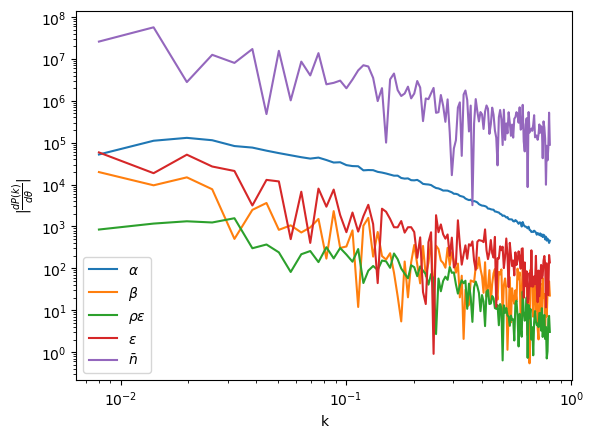

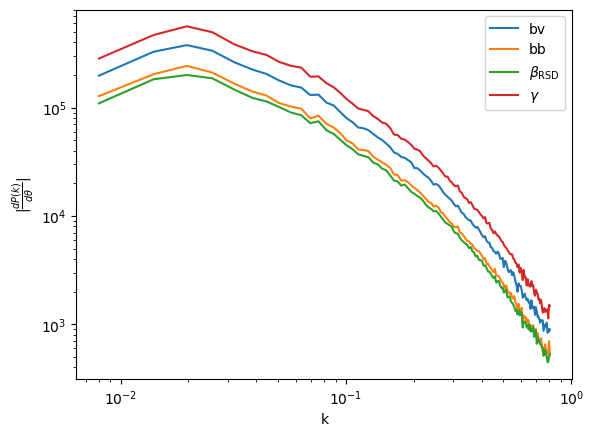

In [27]:
plt.loglog(spec_theta['k'], np.abs(finitediff_alpha), label=r'$\alpha$')
plt.loglog(spec_theta['k'], np.abs(finitediff_beta), label=r'$\beta$')
plt.loglog(spec_theta['k'], np.abs(finitediff_rhoeps), label=r'$\rho\epsilon$')
plt.loglog(spec_theta['k'], np.abs(finitediff_eps), label=r'$\epsilon$')
plt.loglog(spec_theta['k'], np.abs(finitediff_nmean), label=r'$\bar{n}$')

plt.xlabel(r'k')
plt.ylabel(r'$|\frac{dP(k)}{d\theta}$|')

plt.legend()
plt.show()

plt.loglog(spec_theta['k'], np.abs(finitediff_bv), label=r'bv')
plt.loglog(spec_theta['k'], np.abs(finitediff_bb), label=r'bb')
plt.loglog(spec_theta['k'], np.abs(finitediff_betarsd), label=r'$\beta_{\rm RSD}$')
plt.loglog(spec_theta['k'], np.abs(finitediff_gamma), label=r'$\gamma$')
plt.xlabel(r'k')
plt.ylabel(r'$|\frac{dP(k)}{d\theta}$|')

plt.legend()
plt.show()

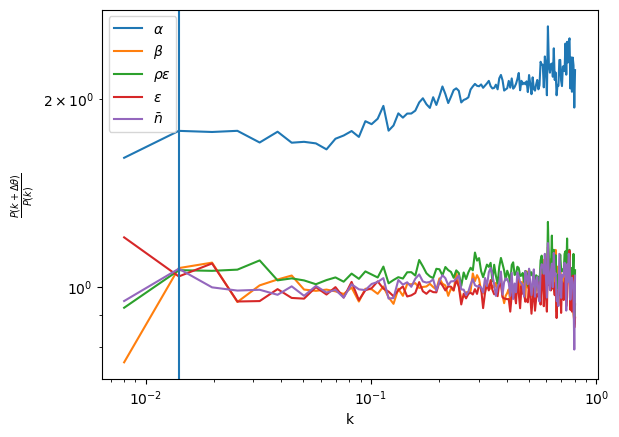

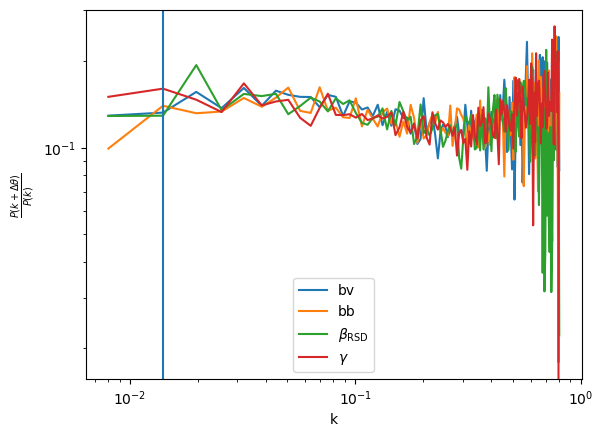

In [142]:
plt.loglog(spec_theta['k'], spec_del_alpha['p0k']/spec_theta['p0k'], label=r'$\alpha$')
plt.loglog(spec_theta['k'], spec_del_beta['p0k']/spec_theta['p0k'], label=r'$\beta$')
plt.loglog(spec_theta['k'], spec_del_rhoeps['p0k']/spec_theta['p0k'], label=r'$\rho\epsilon$')
plt.loglog(spec_theta['k'], spec_del_eps['p0k']/spec_theta['p0k'], label=r'$\epsilon$')
plt.loglog(spec_theta['k'], spec_del_nmean['p0k']/spec_theta['p0k'], label=r'$\bar{n}$')
plt.axvline(0.014)
plt.xlabel(r'k')
plt.ylabel(r'$\frac{P(k + \Delta \theta)}{ P(k)}$')

plt.legend()
plt.show()

plt.loglog(spec_theta['k'], spec_del_bv['p0k']/spec_theta['p0k'], label=r'bv')
plt.loglog(spec_theta['k'], spec_del_bb['p0k']/spec_theta['p0k'], label=r'bb')
plt.loglog(spec_theta['k'], spec_del_betarsd['p0k']/spec_theta['p0k'], label=r'$\beta_{\rm RSD}$')
plt.loglog(spec_theta['k'], spec_del_gamma['p0k']/spec_theta['p0k'], label=r'$\gamma$')
plt.axvline(0.014)
plt.xlabel(r'k')
plt.ylabel(r'$\frac{P(k + \Delta \theta)}{ P(k)}$')

plt.legend()
plt.show()

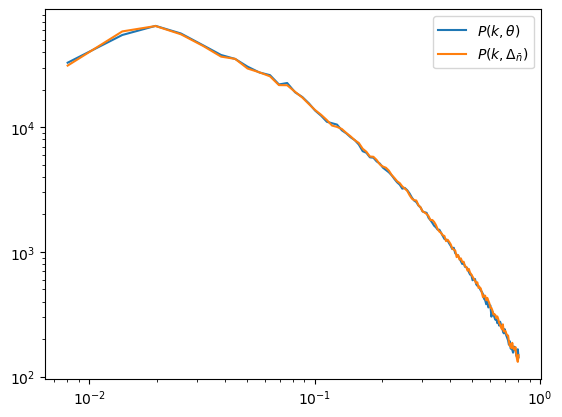

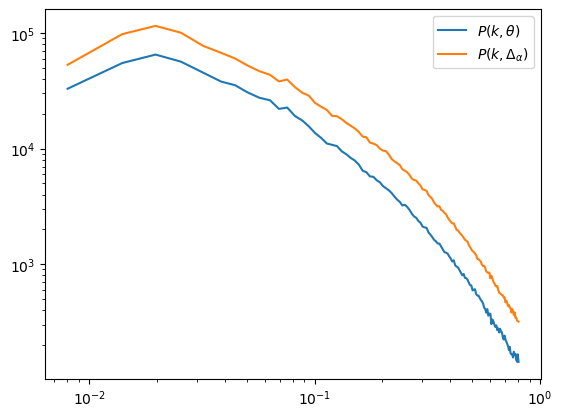

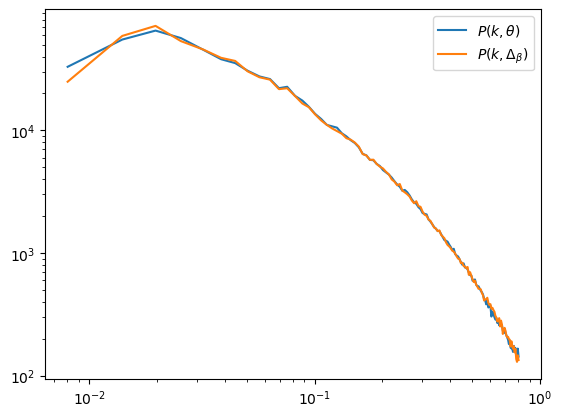

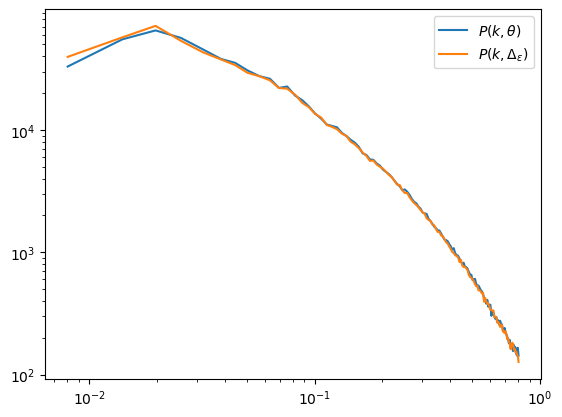

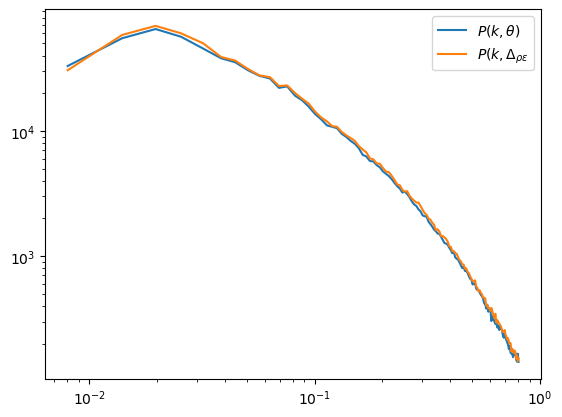

In [42]:
plt.loglog(spec_theta['k'], spec_theta['p0k'], label = r'$P(k,\theta)$')
# plt.loglog(spec_theta['k'], spec_del_alpha['p0k'], label = r'$P(k, \Delta_\alpha)$')
plt.loglog(spec_theta['k'], spec_del_nmean['p0k'], label = r'$P(k, \Delta_{\bar{n}})$')
plt.legend()
plt.show()

plt.loglog(spec_theta['k'], spec_theta['p0k'], label = r'$P(k,\theta)$')
plt.loglog(spec_theta['k'], spec_del_alpha['p0k'], label = r'$P(k, \Delta_\alpha)$')
plt.legend()
plt.show()

plt.loglog(spec_theta['k'], spec_theta['p0k'], label = r'$P(k,\theta)$')
plt.loglog(spec_theta['k'], spec_del_beta['p0k'], label = r'$P(k, \Delta_\beta)$')
plt.legend()
plt.show()

plt.loglog(spec_theta['k'], spec_theta['p0k'], label = r'$P(k,\theta)$')
plt.loglog(spec_theta['k'], spec_del_eps['p0k'], label = r'$P(k, \Delta_\epsilon)$')
plt.legend()
plt.show()

plt.loglog(spec_theta['k'], spec_theta['p0k'], label = r'$P(k,\theta)$')
plt.loglog(spec_theta['k'], spec_del_rhoeps['p0k'], label = r'$P(k, \Delta_{\rho\epsilon}$')
plt.legend()
plt.show()


# plt.loglog(spec_theta['k'], )

# Generate ALPT DM 

In [5]:
xyz = CS.CSbox_alpt(fconfig, outdir, seed=0, make_ics=True, silent=False)

Computing and writing out delta IC
Computing displacement fields at z=0.5
Compiled with MULTITHREAD support, with 10 threads
 >>> web-on: initialising settings....

---> attention: N1= 256
---> attention: redshift= 0


 >>> starting web-on  ...

 >>> web-on initialising cosmological model....

number of chosen redshift snapshots = 1
... writing file posx.dat
... writing file posy.dat
... writing file posz.dat
... writing file posorx.dat
... writing file posory.dat
... writing file posorz.dat
... writing file posor0x.dat
... writing file posor0y.dat
... writing file posor0z.dat
... reading file Quijote_ICs_delta_z127_n256_CIC.DAT
... writing file deltaICOM0.317OL0.683G256V1000.0.dat
... writing file auxreal.dat
... writing file auxim.dat
 >>> dump power-spectrum in : pk_deltaICOM0.317OL0.683G256V1000.0.dat
-->  sample velocity;  z_min, z_max: 0.5  0.5 
... writing file VEZELDx.dat
... writing file VEZELDy.dat
... writing file VEZELDz.dat
-->  calculate values for: 1 snapshots
redshift=0

In [6]:
# "reasonable" priors

def make_thetas(seed, theta0): 
    alpha, beta, dth, rhoeps, eps, nmean, bv, bb, betarsd, gamma = theta0
    rng = np.random.default_rng(seed)
    theta_gal = {
        'alpha':rng.uniform(alpha-0.5*alpha, alpha+0.5*alpha),
        'beta':rng.uniform(beta - 0.2*beta, beta + 0.2*beta),
        'dth':dth,#rng.normal(),
        'rhoeps':rng.uniform(rhoeps-0.2*rhoeps, rhoeps+0.2*rhoeps),
        'eps':rng.uniform(eps-0.2*eps, eps+0.2*eps), 
        'nmean':rng.uniform(nmean-0.2*nmean, nmean + 0.2*nmean)
    }
    theta_rsd = {
        'bv':rng.uniform(bv - bv*0.2, bv + bv*0.2),
        'bb':rng.uniform(bb - bb*0.2, bb + bb*0.2),
        'betarsd':rng.uniform(betarsd - betarsd*0.2, betarsd + betarsd*0.2),
        'gamma': rng.uniform(gamma - 0.2*gamma, gamma + 0.2*gamma)
    }
    return theta_gal, theta_rsd


In [ ]:
def make_thetas(seed): 
    rng = np.random.default_rng(seed)
    theta_gal = {
        'alpha':rng.uniform(0.9615, 2.8845),
        'beta':rng.uniform(1.01265, 3.03795),
        'dth':-0.7889,
        'rhoeps':rng.uniform(7.3437 , 22.03110),
        'eps':rng.uniform(0.2808 , 0.8424), 
        'nmean':rng.uniform(0.000165 , 0.000495)
    }
    theta_rsd = {
        'bv':rng.uniform(0.36445 , 1.09335),
        'bb':rng.uniform(0.5826 , 1.7478),
        'betarsd':rng.uniform(0.6568 , 1.97040),
        'gamma': rng.uniform(0.2472 , 0.7416)
    }
    return theta_gal, theta_rsd

In [ ]:
# import pickle

# np.random.seed(42)
# n_seeds = 100
# seeds = np.random.randint(0,2**32, size = n_seeds)

# priors = []
# for i, seed in enumerate(seeds): 
    



### Vary bias parameters for galaxy assignment; compress to summary statistic

In [7]:
seeds = [1234, 1111, 1010, 1212, 1456, 2356, 2569, 1792, 2000, 1123]
theta0 = np.array([2.8845, 1.82277, -0.7889, 13.21866, 0.67392, 2.4e-05,0.7289, 1.39824, 1.3136, 0.4944])
specs = []
for seed in seeds: 
    theta_gal, theta_rsd = make_thetas(seed,theta0)
    print(theta_gal, theta_rsd)
    xyz_g = CS.CSbox_galaxy(theta_gal, theta_rsd, outdir, silent=True)
    specs.append(stats.Pk_periodic(xyz_g.T, Lbox=1000, Ngrid=256, Nmubin=20, fft='pyfftw', silent=True,rsd=2))



{'alpha': 4.259540477040792, 'beta': 1.7354197519686836, 'dth': np.float64(-0.7889), 'rhoeps': 15.456559224162499, 'eps': 0.6096799033160478, 'nmean': 2.2263331760776298e-05} {'bv': 0.6175506798837543, 'bb': 1.2538109207511097, 'betarsd': 1.218250467539333, 'gamma': 0.5861763115264758}


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


-->Find starting indices ...
-->Start loop over cells of the mesh ...
{'alpha': 3.921028788043488, 'beta': 1.937078558528236, 'dth': np.float64(-0.7889), 'rhoeps': 13.122348488400924, 'eps': 0.7173993398848012, 'nmean': 2.4317116147911324e-05} {'bv': 0.7720233294207107, 'bb': 1.430289539560552, 'betarsd': 1.0801874061665764, 'gamma': 0.476230693877668}
-->Find starting indices ...
-->Start loop over cells of the mesh ...
{'alpha': 1.7162552402026552, 'beta': 1.8488762450906326, 'dth': np.float64(-0.7889), 'rhoeps': 15.42711068997503, 'eps': 0.8037077859532569, 'nmean': 2.734866757579867e-05} {'bv': 0.8006659942043961, 'bb': 1.347579890228453, 'betarsd': 1.3477089019331385, 'gamma': 0.41211343002294537}
-->Find starting indices ...
-->Start loop over cells of the mesh ...
{'alpha': 2.265614818582288, 'beta': 2.0088884086013166, 'dth': np.float64(-0.7889), 'rhoeps': 11.857370545943422, 'eps': 0.6180192453473642, 'nmean': 2.733268937796596e-05} {'bv': 0.6564931106884017, 'bb': 1.453858482

# Make HOD

In [8]:
theta_hod = {
    'logMmin': 13.06,
    'sigma_logM': 0.34,
    'logM0': 13.74,
    'logM1': 14.17,
    'alpha': 0.69,
    'Abias': 0.1, 
    'eta_conc': 1.12,
    'eta_cen': 0.3,
    'eta_sat': 1.26}
hod_quijote = Q.HODgalaxies(theta_hod,'/Users/mcc3842/CosmicSim2025/data/quijote/fiducial/1', z=0.5)
# get redshift-space positions
xyz_q = Q.Box_RSD(hod_quijote, LOS=[0,0,1], Lbox=1000.) # in z-direction
hod_Q_spec = stats.Pk_periodic(xyz_q.T, Lbox=1000, Ngrid=256, Nmubin=20, fft='pyfftw', silent=False,rsd=2)

/opt/homebrew/Caskroom/miniconda/base/envs/simbig/lib/python3.11/site-packages/halotools/empirical_models/phase_space_models/analytic_models/satellites/nfw/biased_nfw_phase_space.py:225: UserWarning: You have selected 18 bins to digitize host halo concentration 
and 96 bins to digitize the galaxy bias parameter.
To populate mocks, the BiasedNFWPhaseSpace class builds a lookup table with shape (18, 96, 101),
one entry for every numerical solution to the Jeans equation.
Using this fine of a binning requires a long pre-computation of 174528 integrals
.Make sure you actually need to use so many bins
  warn(lookup_table_performance_warning.format(*args))
/opt/homebrew/Caskroom/miniconda/base/envs/simbig/lib/python3.11/site-packages/halotools/empirical_models/factories/hod_model_factory.py:890: UserWarning: The composite model received multiple component models 
with a new_haloprop_func_dict that use the conc_NFWmodel key. 
Ignoring the one that appears in the profile component for satellite

------------------
64071 positions in 1000 box
nbar = 0.000064
64071 positions, Ntot=64071
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---


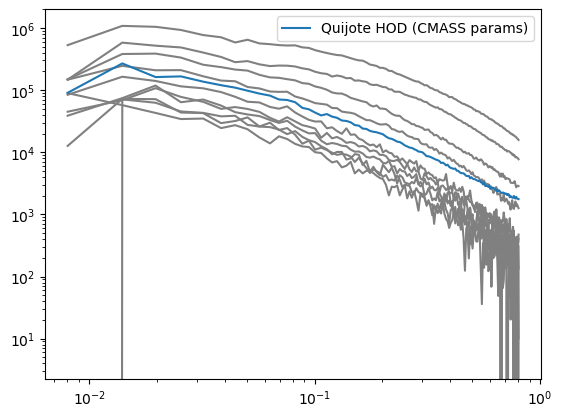

In [9]:
# for spec in specs[:]:
    # plt.plot(spec['k'], spec['p0k'], label=str(seeds[i]))
# pop 5
spec_list = specs.copy()
# spec_list.pop(5)
for spec in spec_list:
    plt.plot(spec['k'], spec['p0k'], color='gray')
# plt.plot(rockstar_spec['k'], rockstar_spec['p0k'], color='black', label='Rockstar')
plt.plot(hod_Q_spec['k'], hod_Q_spec['p0k'], label='Quijote HOD (CMASS params)')
plt.loglog()
plt.legend()

In [ ]:
hod_rockstar = Q.Halos('/Users/mcc3842/CosmicSim2025/data/quijote/fiducial/1', z=0.5)
rockstar_spec = stats.Pk_periodic(np.array(hod_rockstar['Position']).T,Lbox=1000, Ngrid=256, Nmubin=20, fft='pyfftw', silent=False, rsd=2)


------------------
49228 positions in 1000 box
nbar = 0.000049
49228 positions, Ntot=49228
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---
------------------
330909 positions in 1000 box
nbar = 0.000331
330909 positions, Ntot=330909
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---


In [ ]:
# seems like want to bump alpha for overall amplitude, 
# eps for left side peak 
test_theta = {
        'alpha':1.9230 + (1.9230 * 0.5),
        'beta':2.0253 - (2.0253* 0.1),
        'dth':-0.7889,
        'rhoeps':14.6874 - (14.6874*0.1),
        'eps':0.5616 + (0.5616 * 0.2), 
        'nmean': 0.000024#3.3e-4 - (3.3e-4 * 0.2)
    }
test_theta_rsd = {
    'bv': 0.7289,
    'bb': 1.1652 + (1.1652*0.2),
    'betarsd': 1.3136,# - (1.3136*0.2),
    'gamma': 0.4944
}
xyz_g_del = CS.CSbox_galaxy(test_theta, test_theta_rsd, outdir, silent=False)
spec_test = stats.Pk_periodic(xyz_g_del.T, Lbox=1000, Ngrid=256, Nmubin=20, fft='pyfftw', silent=False,rsd=2)


OM0.317OL0.683G256V1000.0_ALPTrs5.000z0.500.dat
Omega_m 0.317000
Reading input ...
Getting number counts via parametric bias ...
Number counts diagnostics (min, max, mean):  0.0 9.0 0.001427292823791504
Preparing galaxy positions ...
Sampling galaxy positions ...
-->Find starting indices ...
-->Start loop over cells of the mesh ...
apply RSD ...
------------------
23946 positions in 1000 box
nbar = 0.000024
23946 positions, Ntot=23946
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---


In [ ]:
# make "reasonable" priors


{'alpha': 2.8845, 'beta': 1.82277, 'dth': -0.7889, 'rhoeps': 13.21866, 'eps': 0.67392, 'nmean': 2.4e-05}
{'bv': 0.7289, 'bb': 1.39824, 'betarsd': 1.3136, 'gamma': 0.4944}
0.3079380386392471


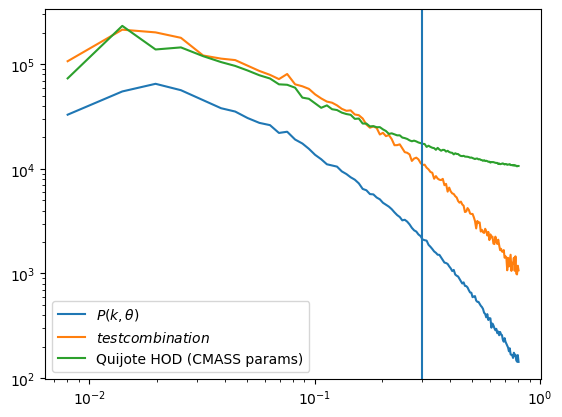

In [156]:
plt.loglog(spec_theta['k'], spec_theta['p0k'], label = r'$P(k,\theta)$')
plt.loglog(spec_theta['k'], spec_test['p0k'], label = r'$test combination$')
# plt.loglog(spec_theta['k'], spec_del_nmean['p0k'], label = r'$P(k, \Delta_{\bar{n}})$')
# plt.loglog(spec_theta['k'], spec_del_alpha['p0k'], label = r'$P(k, \Delta_\alpha)$')
# plt.loglog(spec_theta['k'], spec_del_eps['p0k'], label = r'$P(k, \Delta_\epsilon)$')
# plt.loglog(spec_theta['k'], spec_del_rhoeps['p0k'], label = r'$P(k, \Delta_{\rho\epsilon})$')
plt.loglog(hod_Q_spec['k'], hod_Q_spec['p0k'], label='Quijote HOD (CMASS params)')
plt.axvline(0.3)
plt.legend()

Look at derivatives of the bias parameters to see which govern the slope 

$$ \frac{dP_k(\theta_i)}{d\theta_i}\sim \frac{ P_k(\theta + \Delta \theta_i) - P_k(\theta)}{\Delta \theta_i}$$

vary individual parameters and plot 


### let's try to find good params using mcmc

In [ ]:
test_theta_rsd.values()

# theta = [2.8845, 1.82277, -0.7889, 13.21866, 0.67392, 2.4e-05,0.7289, 1.39824, 1.3136, 0.4944]

dict_values([0.7289, 1.39824, 1.3136, 0.4944])